# VK EgoNet ananlysis

The aim of the project is to provide descriptive analysis of a social network.

In this work, I considered the ego network of social relationships of my friends in the social service VK.

Main parts of work:
* Data parsing
* Network summary
* Structural Analysis
* Community Detection

### **Preparations**

Install the necessary packages and making imports for further work

Install packages

In [444]:
!pip install -q vk_api
!pip install -U -q scipy

Imports

In [445]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import vk_api
import pickle
from tqdm import tqdm
import seaborn as sns
from scipy.spatial.distance import cosine
from networkx.algorithms import community
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

### **Parsing data from VK to create graph**

The VK service has a ready API for developers https://dev.vk.com/reference.

To use it, there is already a ready-made solution in the form of a python package vk-api https://pypi.org/project/vk-api/.

#### Authorisation

In order to use the api methods, you must first log in. Log in with standard logins and password

I use a file 'cred' with credentials, but I also left the option to enter them manually

In [ ]:
login = input("Your login: ")
if login == "":
  print(f"INFO: Parsing cred from file")
  with open("cred", "r+") as cred:
    login = cred.readline().split('\n')[0]
    password = cred.readline()
  print(f"INFO: Done")
else:
  password = input("Your password: ")

Your login: 89824078478
Your password: Zbe+CZN$qvUyFZ5


When authorizing, there are ways to protect against spam as a captcha. Therefore, we use a captcha handler. Which, if necessary, will give a link to the captcha image and send your answer

In [ ]:
def captcha_handler(captcha):
    key = input("Enter captcha code {0}: ".format(captcha.get_url())).strip()
    return captcha.try_again(key)

Log in

In [ ]:
vk_session = vk_api.VkApi(login, password, captcha_handler=captcha_handler)
try:
  vk_session.auth(reauth=True)
  print(f'INFO: Authorization was successful')
except Exception as e:
  print(f'ERROR: {e}')

INFO: Authorization was successful


#### Use API method for getting friends_list and friends_links

Get the api method

In [ ]:
api = vk_session.get_api()

We use the get_fridends method which returns a list of all friends with the specified parameters of the required user, in this case mine.

I save only the information of friends I need: id, name, gender, city

In [ ]:
main_user_id = 179977913
myFriends = api.friends.get(user_id=main_user_id, fields = ['name', 'sex', 'city'])['items']
myFriends_list = np.array([[friend['id'], 
  friend['last_name'] + " " + friend['first_name'], 
  'W' if friend['sex']==1 else 'M', 
  friend['city']['title'] if 'city' in friend else '']
 for friend in myFriends])

print(f'Example of getting users data: {myFriends[0]}')
print(f'Example of saving users data: {myFriends_list[0]}')

Example of getting users data: {'id': 4825797, 'city': {'id': 82, 'title': 'Магнитогорск'}, 'track_code': '16b00027IE8fAxUruzbxKe-nAIK-N_Kcu9sXxQvFBBm4tzpuV_BNJBc1JivnYaZ_1gH1SilHi5-7snKrbw', 'sex': 2, 'first_name': 'Александр', 'last_name': 'Баскаков', 'can_access_closed': True, 'is_closed': False}
Example of saving users data: ['4825797' 'Баскаков Александр' 'M' 'Магнитогорск']


Edges in our future graph denotes like a friendly relationship between people. Again using API method we find friends of each my friend, and if it is in myFriends we save this link

In [ ]:
friends_f_amount = []
friends_links_list = []
for f_id in tqdm(myFriends_list[:,0]):
    try :
      friendsId_list = api.friends.get(user_id = f_id)['items']
    except Exception as e:
      friendsId_list = [0]
      print(f'ERROR: {f_id} {e}')
    friends_f_amount += [len(friendsId_list)]
    new_links = [(int(f_id), friend) for friend in list(set(myFriends_list[:,0].astype(int)).intersection(friendsId_list))]
    friends_links_list += new_links

 48%|████▊     | 66/138 [00:32<00:35,  2.03it/s]

ERROR: 170075509 [18] User was deleted or banned


100%|██████████| 138/138 [01:07<00:00,  2.04it/s]


Concantinate new attribute  to another

In [ ]:
myFriends_list = np.concatenate((myFriends_list, np.reshape(friends_f_amount, (-1, 1))), axis=1)

Now we have
* myFriends_list = {[id,name,sex, city,f_amount]}
* friends_links_list = {(id_i, id_j)}

Save this lists to file for futher rescure if we need

In [ ]:
import pickle
with open('myFriends_list', 'wb') as fp:
    pickle.dump(myFriends_list, fp)
with open('friends_links_list', 'wb') as fp:
    pickle.dump(friends_links_list, fp)

###**Create EgoNet**

Import friends_list(nodes) and friends_links(edges)

In [446]:
with open ('myFriends_list', 'rb') as fp:
    myFriends_list = pickle.load(fp)
with open ('friends_links_list', 'rb') as fp:
    friends_links_list = pickle.load(fp)
print(f'Friend example [id, name, sex, city, f_amount]={myFriends_list[0]}')
print(f'Link example (id1, id2)={friends_links_list[0]}')

Friend example [id, name, sex, city, f_amount]=['4825797' 'Баскаков Александр' 'M' 'Магнитогорск' '539']
Link example (id1, id2)=(4825797, 283943041)


Create graph,add nodes with atributes and add edges

In [447]:
G = nx.Graph()
for f in myFriends_list:
  G.add_node(int(f[0]), name=f[1],  sex=f[2], city=f[3], f_amount=int(f[4]))
nodes = G.nodes()
G.add_edges_from(friends_links_list)

##### Subgraphs

Usually there are separate communities that may not intersect with each other. That is, EgoNet may not be connected.

Let's look at the number of components in the graph

In [448]:
components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
if len(components)>1:
  print(f'Graph is not connected.\nAmount of components: {len(components)}')
  print('Components length:', [len(c) for c in components])

Graph is not connected.
Amount of components: 13
Components length: [104, 22, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


As we can see, there are two components that stand out in terms of the number of nodes. Taking into account the fact that after school I moved studing to Moscow, most likely the second component is people from my past city of Nadym

Therefore, we create two subgraphs of interest to us

In [449]:
G1 = G.subgraph(components[0])
G2 = G.subgraph(components[1])

##### Plot graphs

Let's write a function to display a graph

In [450]:
def simple_graph_plot(graph, 
                      plot_name='Ego Network',
                      figsize=(12*2, 6*2),
                      edges_width=0.2,
                      node_size=10,
                      title_size=15*1.8,
                      label_size=7, 
                      node_size_type='x', #'f'-friend amount
                      node_color_type='n', #'s'-sex
                      draw_name_label=False):
  plt.figure(figsize=figsize)
  layout = nx.kamada_kawai_layout(graph)

  nodes = graph.nodes()
  if node_size_type=='f':
    #size by amount of all friend
    node_size_list = [nodes[n]['f_amount']/3+20 for n in nodes]
  elif node_size_type=='d':
    #size by degree in graph
    node_size_list = np.array(list(graph.degree), dtype ='int64')[:,1]*6
  else:
    node_size_list = np.ones(len(nodes)) * node_size

  if node_color_type=='s':
    #color by sex
    blue = np.array([0, 0, 200])/255
    red =np.array([200, 0, 0])/255
    node_color_list = [blue if nodes[id]['sex']=='M' else red for id in nodes]
  else:
    #one color
    node_color=np.array([0, 0, 200])/255
    node_color_list = [node_color] * len(graph.nodes)

  nx.draw_networkx_nodes(graph, pos=layout, node_size=node_size_list, node_color = node_color_list)
  nx.draw_networkx_edges(graph, pos=layout, width=edges_width)
  if draw_name_label:
    nx.draw_networkx_labels(G, pos=layout, labels=nx.get_node_attributes(graph, "name"), font_size=label_size, verticalalignment='bottom')
  plt.title(plot_name, fontdict = {'fontsize' : title_size})
  plt.axis('off')
  plt.show()

Let's display the general EgoNet. 

PS: nodeSize by amount of friends, nodeColor is red(women) and blue(men)

Giant component

In general, you can see about three-four clear communities in this subgraph.If you look at the names of the nodes, it becomes clear that these are acquaintances from the university_bachelor relatives, university_master, friends from the hostel and work.(next, we will try to detect community data using algorithms)

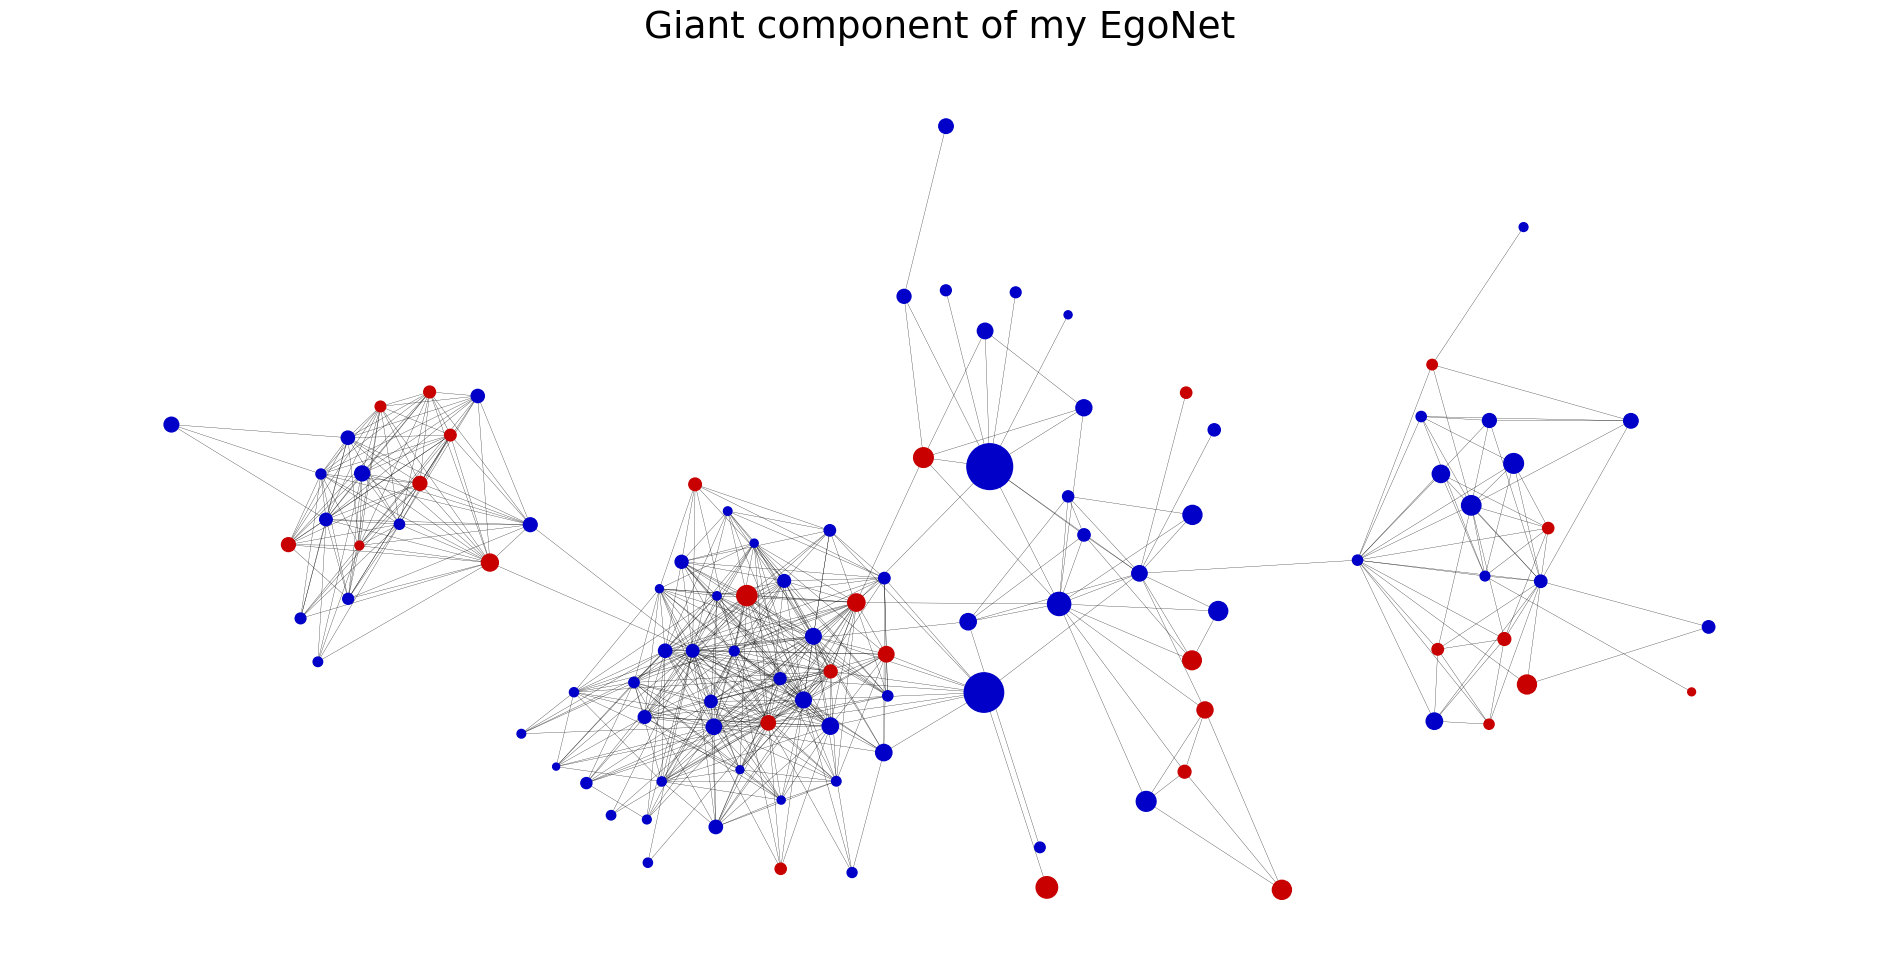

In [451]:
simple_graph_plot(G1,'Giant component of my EgoNet', 
                  node_size_type='f', 
                  node_color_type='s',
                  draw_name_label=False)

In the second subgraph, two communities are clearly visible, friends from school and friends from the Artek camp. They are connected by two of my friends (one of whom traveled with me)

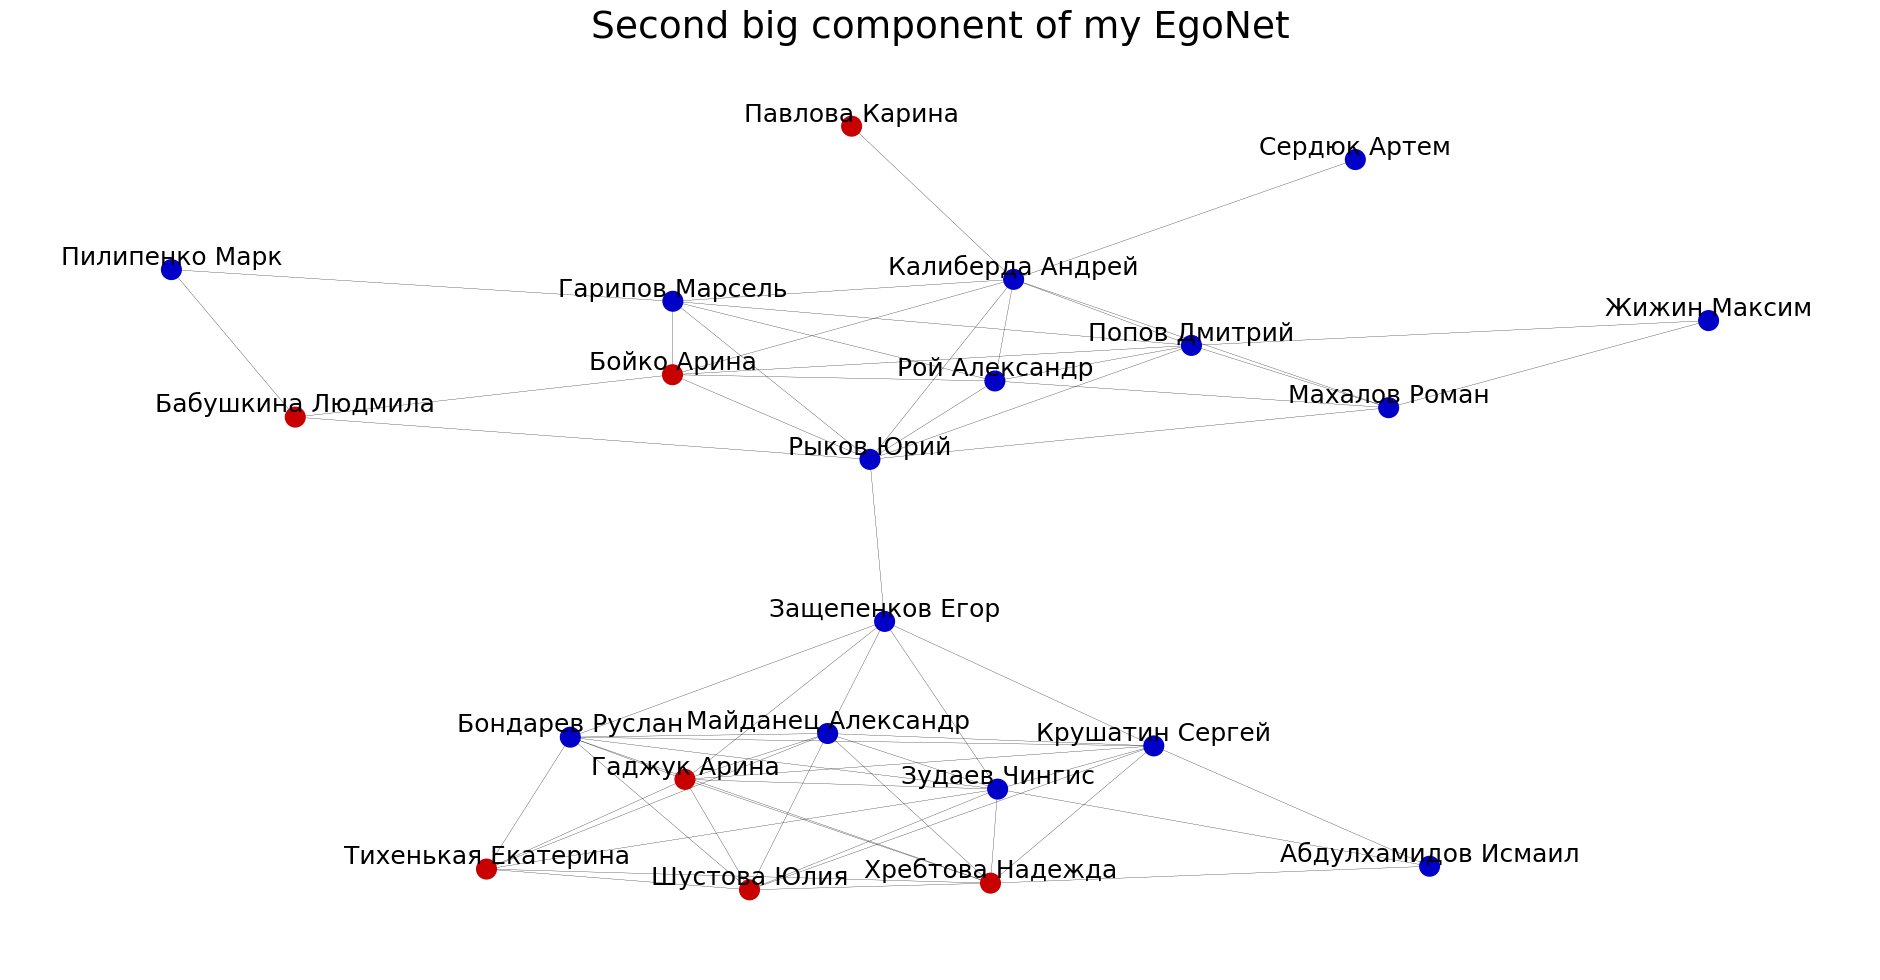

In [452]:
simple_graph_plot(G2,'Second big component of my EgoNet', 
                  node_size=200, 
                  label_size=18,
                  node_color_type='s', 
                  draw_name_label=True)

### **Network summary**



Consider the main parameters of our graph.
Given the fact that this is Egonet of friends and previous discoveries, graph is:
* Undirected
* Unweighted
* Node attributes: vk_user_id, name, sex, city, friends_amount

##### Main numerical parameters

Write simple function to get main graph parametrs

In [10]:
def print_graph_parametrs(graph, graph_name='Graph'):
  print(f'{graph_name}:')
  print('  Number of nodes:', graph.order())
  print('  Number of edges:', graph.size())
  print('  Average degree:', np.mean(np.array(list(graph.degree))[:,1]))
  if len(list(nx.connected_components(graph)))==1:
    print('  Radius:', nx.radius(graph))
    print('  Diameter:', nx.diameter(graph))
    print('  Average shortest path length:', nx.average_shortest_path_length(graph))
  print('  Average clustering coefficient:', nx.average_clustering(graph))
  print('  Global clustering coefficient:', nx.transitivity(graph))
  print()

Here are the main numbers of the three networks

In [124]:
print_graph_parametrs(G,'EGO NET')
print_graph_parametrs(G1,'GIANT SUBGRAPH')
print_graph_parametrs(G2,'SECOND SUBGRAPH')

EGO NET:
  Number of nodes: 138
  Number of edges: 626
  Average degree: 9.072463768115941
  Average clustering coefficient: 0.5953701002872802
  Global clustering coefficient: 0.6085074142223185

GIANT SUBGRAPH:
  Number of nodes: 104
  Number of edges: 562
  Average degree: 10.807692307692308
  Radius: 4
  Diameter: 8
  Average shortest path length: 3.3778939507094847
  Average clustering coefficient: 0.6517471996180733
  Global clustering coefficient: 0.6029080252479712

SECOND SUBGRAPH:
  Number of nodes: 22
  Number of edges: 63
  Average degree: 5.7272727272727275
  Radius: 3
  Diameter: 5
  Average shortest path length: 2.5757575757575757
  Average clustering coefficient: 0.6536075036075036
  Global clustering coefficient: 0.7438692098092643



In the future, we will consider only the giant component of our network, since smaller components are not so interesting in the analysis, and the main egonet is disconnected and it will not be possible to apply some algorithms to it.

##### Clustering coefficient histogram

Clustering coefficient of a node  Ci  contains information about relationship between nearest neighbors.  Ci=0  means that there is no links between neighbors and  Ci=1  means that there are all possible links between them.

In [12]:
def plot_clust_coef_hist(graph_name,graph):
    plt.figure(figsize=(4,4))
    plt.hist(nx.clustering(graph).values(), bins=25, rwidth=0.8)
    plt.title(f"{graph_name} Clustering coefficient histogram")
    plt.xlabel('Clustering coefficient')
    plt.ylabel('Frequency')
    plt.show()

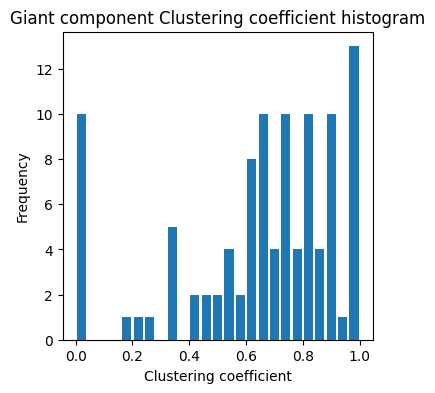

Average clustering coefficient: 0.6517471996180733


In [126]:
plot_clust_coef_hist("Giant component", G1)
print(f'Average clustering coefficient: {nx.average_clustering(G1)}')

In general, the histogram shows fairly high cluster coefficients, which correlates with the structure that we saw

##### Average path length histogram

In [14]:
def plot_av_path_hist(graph_name,graph):
    values = [np.mean(list(lengths.values())) for node, lengths in nx.shortest_path_length(graph)]
    plt.figure(figsize=(4,4))
    plt.hist(values, bins=25, rwidth=0.8)
    plt.title(f"{graph_name} Average path length histogram")
    plt.xlabel('Path length')
    plt.ylabel('Frequency')
    plt.show()

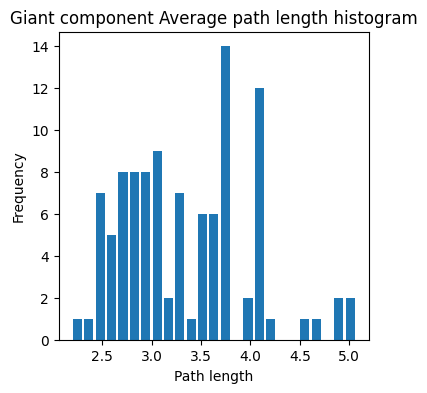

In [15]:
plot_av_path_hist('Giant component',G1)

##### Degree distribution and CDF

Some usefull functions

In [16]:
def plot_deg_distr_hist(graph_name,graph):
    degrees = [degree for (node, degree) in graph.degree]
    plt.figure(figsize=(4,4))
    plt.hist(degrees, bins=20, rwidth=0.8)
    plt.title(f"{graph_name} node degree distribution histogram")
    plt.xlabel('Node degree')
    plt.ylabel('Frequency')
    plt.show()

In [17]:
def empirical_cdf(graph):
    hist = nx.degree_histogram(graph)
    return np.cumsum(hist) / np.sum(hist)

In [18]:
def empirical_pdf(graph):
    degrees = [degree for (node, degree) in graph.degree]
    degrees_distribution = pd.value_counts(degrees)
    degrees_distribution = degrees_distribution.sort_index()
    pdf_pandas = degrees_distribution/len(degrees)
    return [pdf_pandas.index.to_numpy(),pdf_pandas.to_numpy()]

In [19]:
def plot_cdf(graph):
    plt.figure(figsize=(5,4))
    plt.plot(empirical_cdf(graph))
    plt.title("CDF")
    plt.xlabel('Node degree')
    plt.show()

In [20]:
def plot_log_pdf(graph):
    x, y = empirical_pdf(graph)
    plt.figure(figsize=(5,3)) 
    plt.loglog(x, y, '.')
    plt.title("PDF in log-log scale")
    plt.xlabel('Node degrees')
    plt.ylabel('PDF')

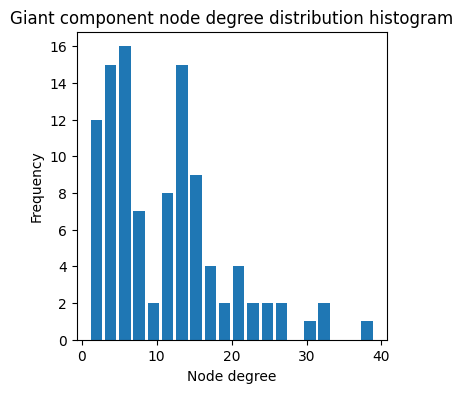

In [21]:
plot_deg_distr_hist('Giant component',G1)

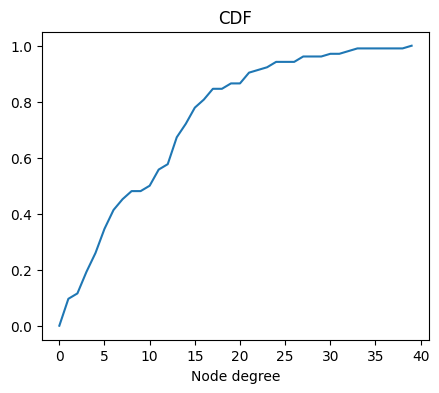

In [22]:
plot_cdf(G1)

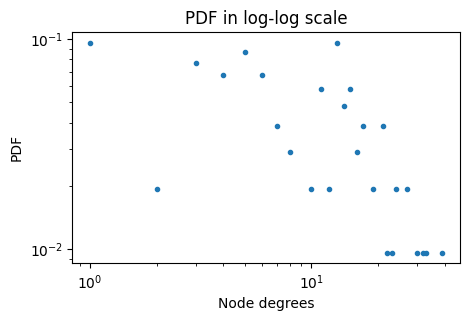

In [23]:
plot_log_pdf(G1)

#### Estimation parameters of Power Law by MLE

Real social networks are quite close to the power law of distribution and can be described by it.

$p(x) = Cx^{-\alpha}$

Let us estimate $\alpha$ and $x_\min$ of our social network using maximum likelihood.The resulting line should pass between logarithmic PDF points

In [24]:
import scipy
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

def power_law_cdf(x, alpha=3.5, x_min=1):
    return 1 - (x / x_min)**(-alpha + 1)

def alpha_fun(x_min, new_degrees):
    sum = 0.001
    n = len(new_degrees)
    for i in new_degrees:
        sum += np.log(i/x_min)
    return 1+n/sum

def mle_power_law_params(degree_sequence):
    D_min = 1000000000
    for x in np.sort(degree_sequence):
        x = np.round(x)
        new_degrees = []
        for i in degree_sequence:
            if i >= x:
                new_degrees.append(i) 
        alpha = alpha_fun(x, new_degrees)
        if len(new_degrees) != 0:
            D = scipy.stats.kstest(new_degrees, power_law_cdf, args=(alpha, x))[0]
            if D_min > D:
                alpha_min = alpha
                x_min = x
                D_min = D
    return alpha_min, x_min 

In [25]:
degrees = [degree for (node, degree) in G1.degree]
alpha_min, x_min = mle_power_law_params(degrees)
print('Take our estimate parameters')
print('alpha_min:', alpha_min)
print('x_min:', x_min)

Take our estimate parameters
alpha_min: 4.196826805945609
x_min: 14


If our network obeys power law, we will be able to draw an optimal line in a log-log scale between points.

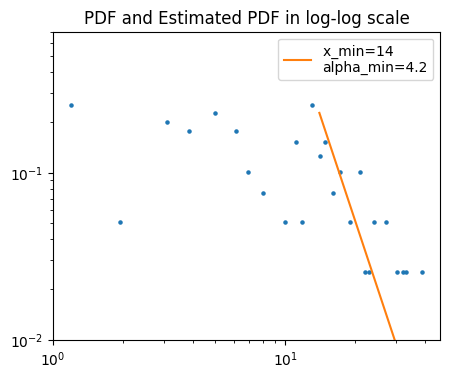

In [26]:
plt.figure(figsize=(5,4)) 
hist, bin_edges = np.histogram(degrees, bins=100, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('PDF and Estimated PDF in log-log scale')

x_space = np.linspace(x_min, max(degrees), 100)
plt.plot(x_space, power_law_pdf(x_space, alpha_min, x_min), 
         label=f'x_min={x_min} \nalpha_min={round(alpha_min,2)}', c='tab:orange')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.01, 0.7)
plt.legend()
plt.show()

In general, the resulting line passes through the points quite well, taking into account the fact that we do not have a large enough network (100 nodes) to fit perfectly into Power low

### **Structural Analysis**

#### The closest random graph model similar to our social network (ER, BA, WS)


Let's try to see which random graph generation models can most closely describe our network.
We observe 3 methods:
* Erdos-Renyi
* Watts-Strogatz
* Barabashi Albert

Our perferct graph condition

In [261]:
cdf = empirical_cdf(G1)
conditions = {
  "number_nodes": len(list(G1.nodes())),
  "radius": [nx.radius(G1), 2],
  "diameter": [nx.diameter(G1), 3],
  "average_clustering": [nx.average_clustering(G1), 0.2],
  "average_path_length": [nx.average_shortest_path_length(G1), 0.5],
  "number_cc": [1, 1],
  "degree_cdf": [np.arange(0,len(cdf)),
                cdf]}

Function for getting main generated graph score

In [262]:
def get_all_stats(G):
  result = {}
  conn_comps = list(nx.connected_components(G))
  largest_cc = max(conn_comps, key=len)
  subG = G.subgraph(largest_cc)
  result['radius'] = nx.radius(subG)
  result['diameter'] = nx.diameter(subG)
  result['average_clustering'] = nx.average_clustering(G)
  result['average_path_length'] = nx.average_shortest_path_length(subG)
  return result

Introduce an evaluation system base on main sats

In [263]:
def score(true, pred, sigma):
  res = np.exp(-(true - pred) ** 2 / (2 * sigma ** 2))
  return round(res, 4)

def diff_metric(result, condition, printing=True):
    keys = ['radius', 'diameter', 'average_clustering', 'average_path_length']
    S = 0
    for key in keys:
      value, sigma = conditions[key]
      s = score(value, result[key], sigma)
      if printing:
        print(key,': ', s * 100) 
      S += 1 / 5 * s 
    S * 100
    if printing:
      print('SCORE:',S)
    return S

##### Erdos-Renyi model(random graph)

Erdos Renyi model (random graph) — each pair of n nodes are connected with some fixed probability  p

We will generate a graph using this model with varying parameters and keep the best

In [431]:
NUM_EDGES = len(list(G1.edges()))
NUM_NODES = len(list(G1.nodes()))
p = NUM_EDGES / (NUM_NODES * (NUM_NODES - 1)) * 2

p = [i/100 for i in range(1,20)]
top_score = 0
for i in p:
  ER_graph = nx.erdos_renyi_graph(NUM_NODES, i)
  stats = diff_metric(get_all_stats(ER_graph), conditions, False)
  if stats>0.5:
      print(f'score: {stats}, p:{i}')
  if stats-top_score>0.001:
    top_score = stats
    ER_TOP_graph = ER_graph
ER_top_score = top_score

score: 0.58782, p:0.04
score: 0.56004, p:0.05


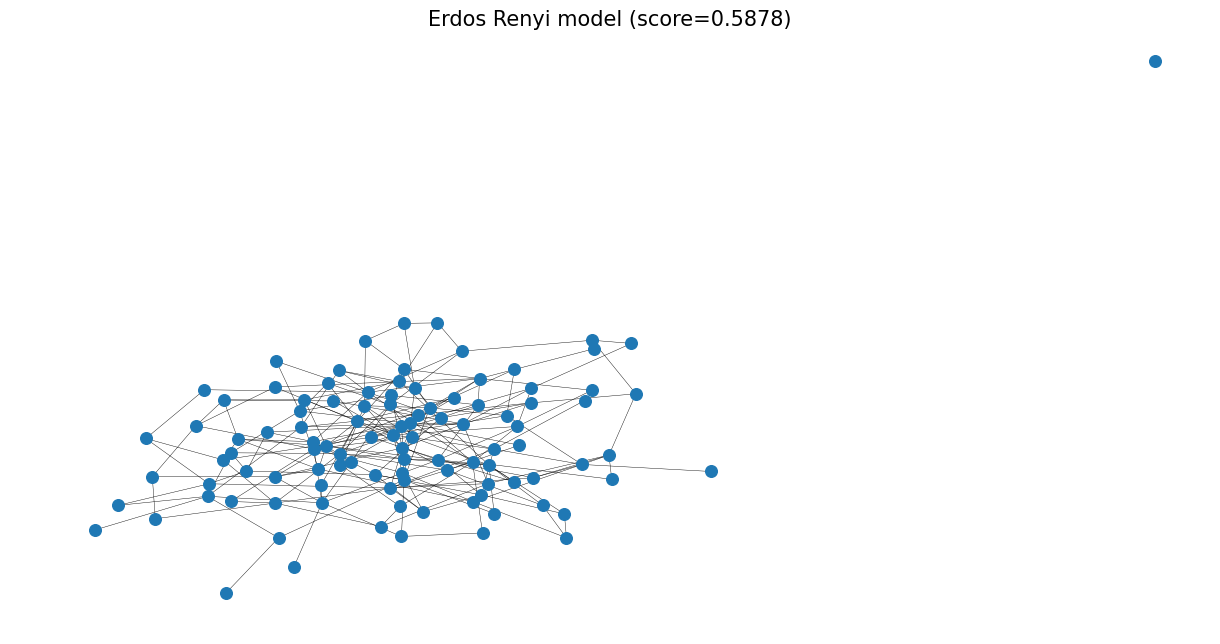

Graph parametrs
{'radius': 4, 'diameter': 7, 'average_clustering': 0.03148656898656899, 'average_path_length': 3.2906910336950315}

Evaluation score
radius :  100.0
diameter :  94.6
average_clustering :  0.8200000000000001
average_path_length :  98.49
SCORE: 0.58782


0.58782

In [458]:
plt.figure(figsize=(12,6))
nx.draw(ER_TOP_graph, node_size=70, width=0.3)
plt.title(f'Erdos Renyi model (score={round(ER_top_score,4)})', fontdict = {'fontsize' : 15})
plt.show()
print('Graph parametrs')
print(get_all_stats(ER_TOP_graph))
print('\nEvaluation score')
diff_metric(get_all_stats(ER_TOP_graph), conditions)

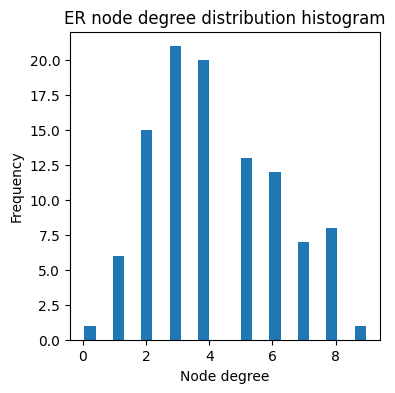

In [433]:
plot_deg_distr_hist("ER",ER_TOP_graph)

##### Watts-Strogatz 

Watts and Strogatz - Single parameter model, interpolation between regular lattice and random graph. It is a random graph generation model that produces graphs with small-world properties, including short average path lengths and high clustering

In [434]:
import itertools
k = [i for i in range(2,15)]
p = [i/100 for i in range(2,15)]
top_score = 0
for i in np.array([x for x in itertools.product(k, p)]):
  WS_graph = nx.watts_strogatz_graph(NUM_NODES, int(i[0]), i[1])
  stats = diff_metric(get_all_stats(WS_graph), conditions, False)
  if stats>0.74:
    print(f'score: {stats}, k:{i[0]}, p:{i[1]}')
  if stats-top_score>0.001:
    top_score = stats
    WS_TOP_graph = WS_graph
WS_top_score = top_score

score: 0.7416600000000001, k:8.0, p:0.05
score: 0.769, k:9.0, p:0.05
score: 0.7576200000000001, k:9.0, p:0.06
score: 0.75544, k:10.0, p:0.02
score: 0.74434, k:10.0, p:0.03
score: 0.7560800000000001, k:10.0, p:0.04
score: 0.7511200000000001, k:11.0, p:0.03
score: 0.74582, k:11.0, p:0.04


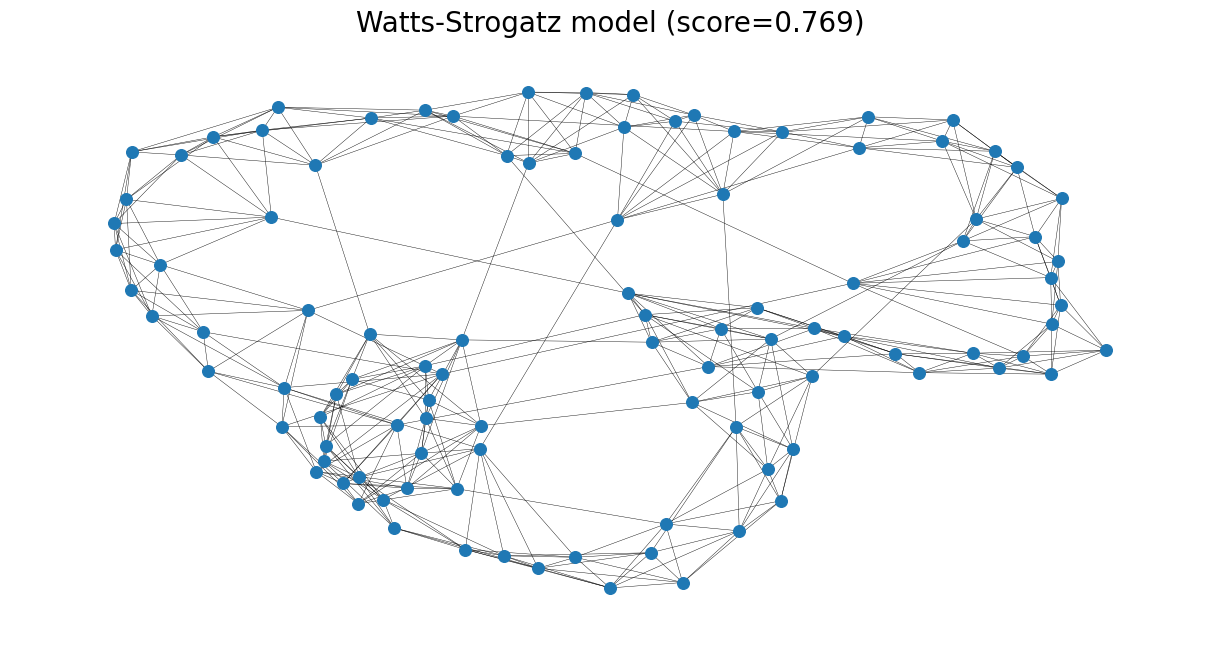

Graph parametrs
{'radius': 4, 'diameter': 7, 'average_clustering': 0.5616376678876677, 'average_path_length': 3.4251306945481703}

Evaluation score
radius :  100.0
diameter :  94.6
average_clustering :  90.35
average_path_length :  99.55000000000001
SCORE: 0.769


0.769

In [456]:
plt.figure(figsize=(12,6))
nx.draw(WS_TOP_graph, node_size=70, width=0.3)
plt.title(f'Watts-Strogatz model (score={round(WS_top_score,4)})', fontdict = {'fontsize' : 20})
plt.show()
print('Graph parametrs')
print(get_all_stats(WS_TOP_graph))
print('\nEvaluation score')
diff_metric(get_all_stats(WS_TOP_graph), conditions)

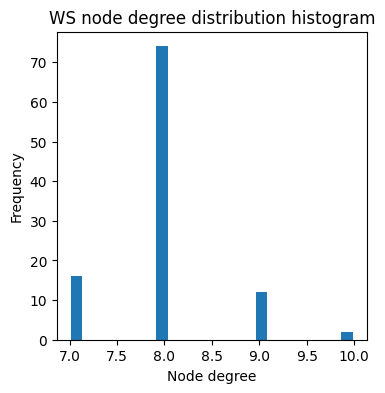

In [436]:
plot_deg_distr_hist("WS",WS_TOP_graph)

##### Barabashi Albert

The Barabási–Albert (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism.
Dynamic growth: start at t = 0 with n0 nodes and m0 ≥ n0 edges


In [437]:
m = [i for i in range(1,25)]
top_score = 0
for i in m:
  BA_graph = nx.barabasi_albert_graph(NUM_NODES, i)
  stats = diff_metric(get_all_stats(BA_graph), conditions, False)
  if stats>0.4:
      print(f'score: {stats}, m:{i}')
  if stats-top_score>0.001:
    top_score = stats
    BA_TOP_graph = BA_graph
BA_top_score = top_score

score: 0.5087200000000001, m:2


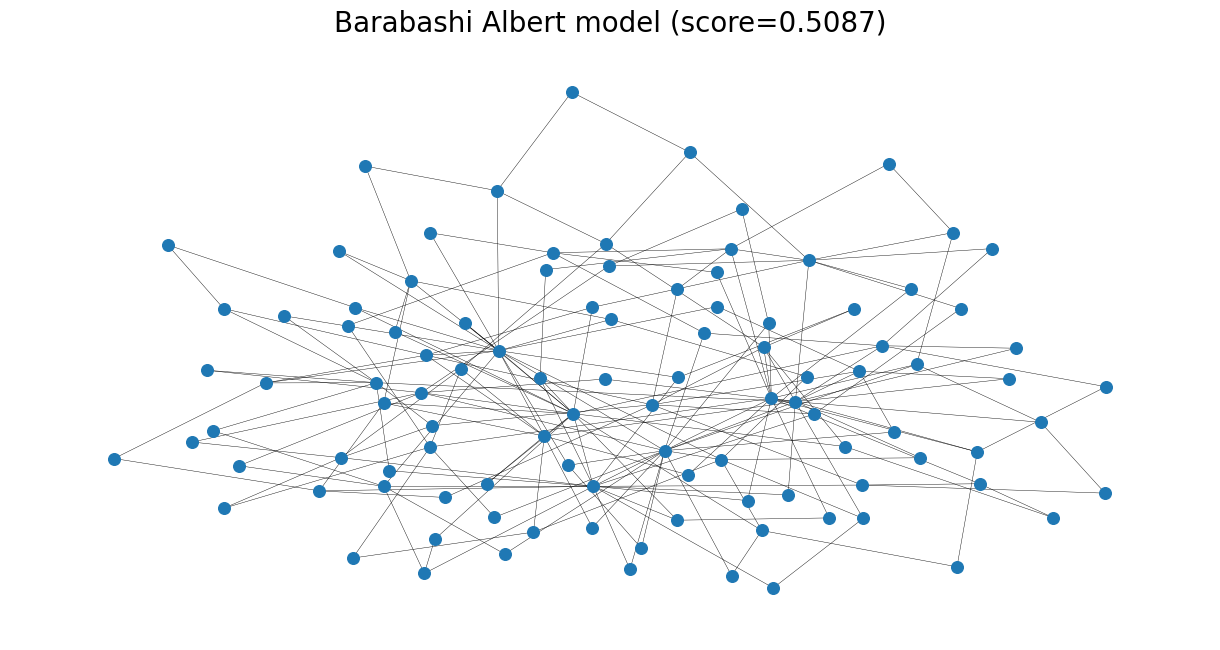

Graph parametrs
{'radius': 3, 'diameter': 6, 'average_clustering': 0.10899115810032102, 'average_path_length': 3.0778566094100075}

Evaluation score
radius :  88.25
diameter :  80.07
average_clustering :  2.52
average_path_length :  83.52000000000001
SCORE: 0.5087200000000001


0.5087200000000001

In [441]:
plt.figure(figsize=(12,6))
nx.draw(BA_TOP_graph, node_size=70, width=0.3)
plt.title(f'Barabashi Albert model (score={round(BA_top_score,4)})', fontdict = {'fontsize' : 20})
plt.show()
print('Graph parametrs')
print(get_all_stats(BA_TOP_graph))
print('\nEvaluation score')
diff_metric(get_all_stats(BA_TOP_graph), conditions)

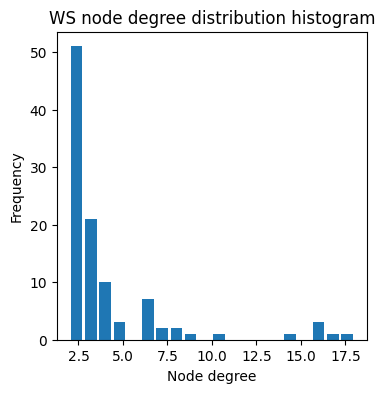

In [439]:
plot_deg_distr_hist("WS",BA_TOP_graph)

#### Our best choice

In our case, we got the best parameters from the Watts-Strogatz model, which is more or less expected since our graph is quite small and closer in characteristics to small-world proprties(path lengths, high clustering). 
Of course, there are also weaknesses, or rather the distribution of the degrees of nodes, which are not very suitable for real network distribution.

Therefore, for better results, it is possible to use more complex models.

#### Centralities


Let's try to find the central nodes in our graph.

There are various ways to evaluate
* The degree centrality of a node is simply its degree—the number of edges it has
* The closeness centrality of a node measures its average farness (inverse distance) to all other nodes
* Betweenness Centrality measures how often a node appears on shortest paths between nodes in the network
* Katz centrality computes the relative influence of a node within a network by measuring the number of the immediate neighbors (first degree nodes) and also all other nodes in the network that connect to the node under consideration through these immediate neighbors
* Eigenvector centrality is a measure of the influence a node has on a network


In [454]:
cases = [['Degree centrality', nx.degree_centrality, 2000, 0], 
         ['Closeness centrality', nx.closeness_centrality, 1500, 0], 
         ['Betweenness centrality', nx.betweenness_centrality, 1500, 50],
         ['Katz centrality', nx.katz_centrality, 1500, 50],
         ['Eigenvector centrality', nx.eigenvector_centrality, 1500, 50]]
         #['PageRank value', nx.pagerank, 30000, 0]]
for title, take_centr, scale, bias in cases:
    if(title=='Katz centrality'):
      centrality = take_centr(G1, alpha=1/30, max_iter=10000)
    else:
      centrality = take_centr(G1)

    centrality_list = sorted(list(centrality.items()), key=lambda x: -x[1])
    df_centrality =  pd.DataFrame(centrality_list[:10], columns=['id', 'centrality'])
    df_centrality['Name'] = df_centrality['id'].apply(lambda id: nodes[id]['name'])

    print(f'Top {title} nodes')
    display(df_centrality)

    centrality_values = np.array(list(centrality.values()))
    plt.figure(figsize=(20, 10))
    pos = nx.kamada_kawai_layout(G1)
    nx.draw(G1,
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_size=centrality_values*scale + bias,
            node_color=centrality_values)
    plt.title(title, fontdict = {'fontsize' : 30})
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In general, the central nodes do not vary much depending on the methods. The only highlight is Betweenness centrality, since these are the people who connect my communities of people and they do not have to be the center of their hubs

#### Comparison of centralities

In [166]:
cases_for_corr = [['Degree centrality', list(nx.degree_centrality(G1).values())], 
         ['Closeness centrality',  list(nx.closeness_centrality(G1).values())], 
         ['Betweenness centrality',  list(nx.betweenness_centrality(G1).values())],
         ['Katz centrality',  list(nx.katz_centrality(G1, 1/30, 10000).values())],
         ['Eigenvector centrality',  list(nx.eigenvector_centrality(G1).values())]]

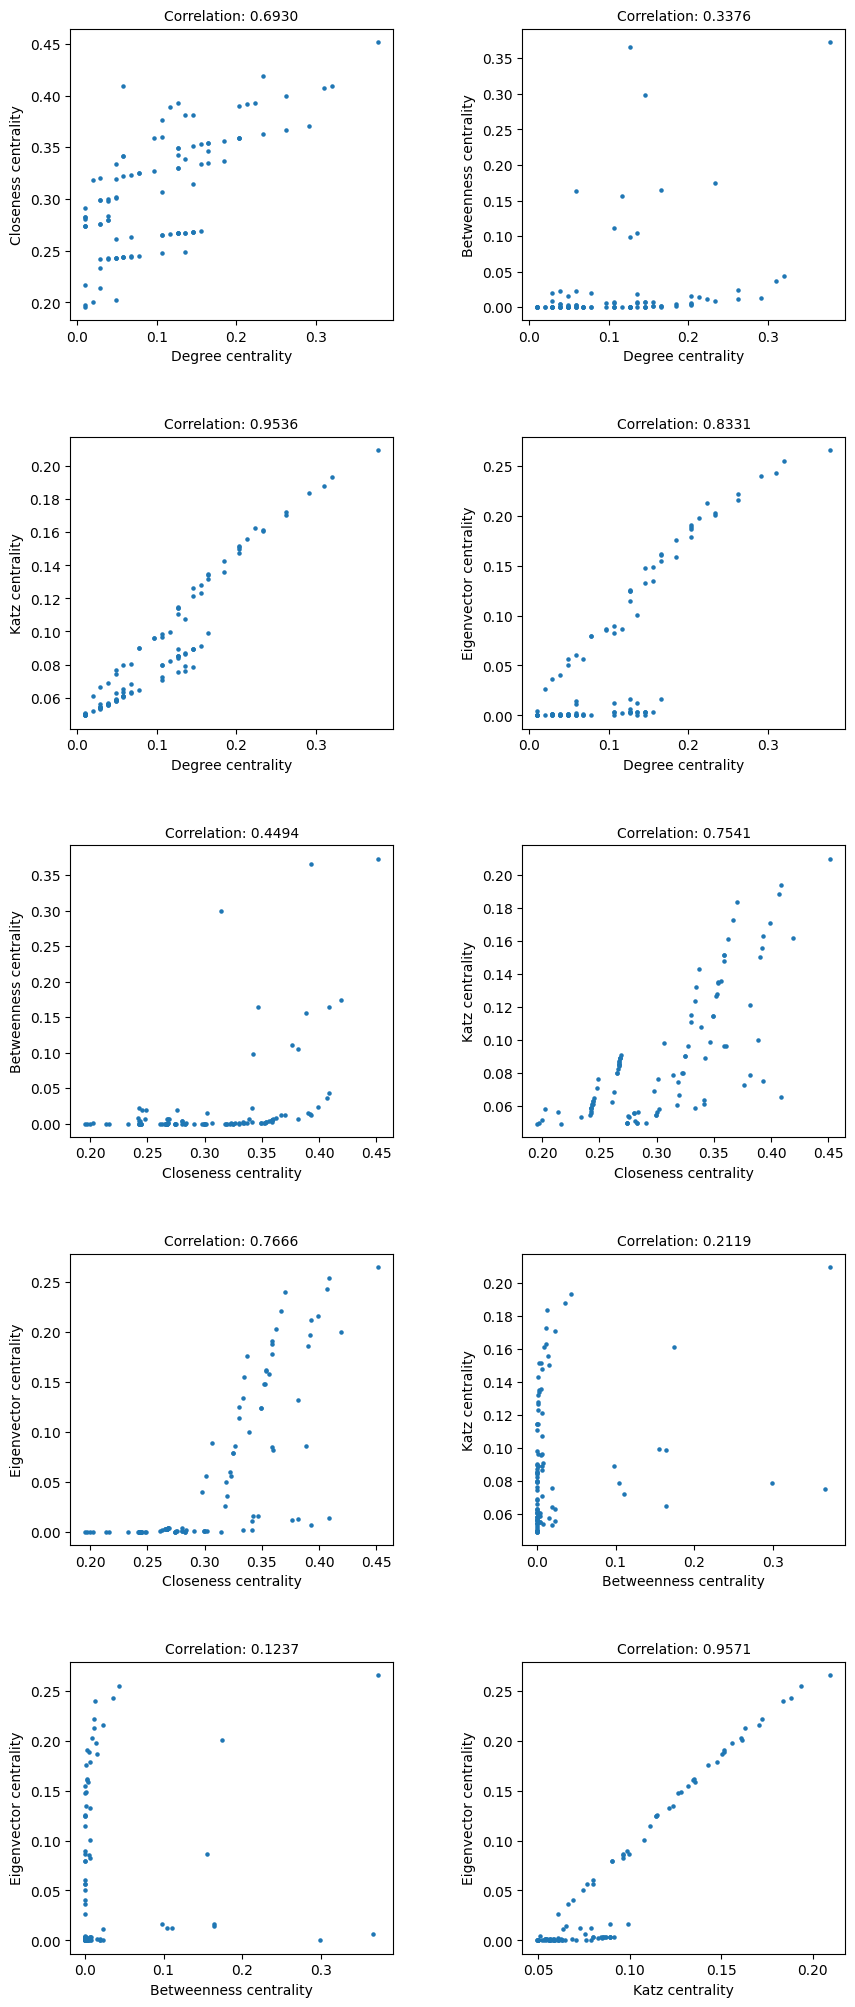

In [167]:
import scipy
plt.figure(figsize=(2*5, 5*5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
k = 1
for i in range(len(cases_for_corr)):
    for j in range(i + 1, len(cases_for_corr)):
        i_label, i_vals = cases_for_corr[i]
        j_label, j_vals = cases_for_corr[j]
        correlation = scipy.stats.pearsonr(i_vals, j_vals)[0]
        plt.subplot(5, 2, k)
        plt.scatter(i_vals, j_vals, s=5)
        plt.title('Correlation: {:.4f}'.format(correlation),  fontdict = {'fontsize' : 10})
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1

Comparison of centralities with PageRank value

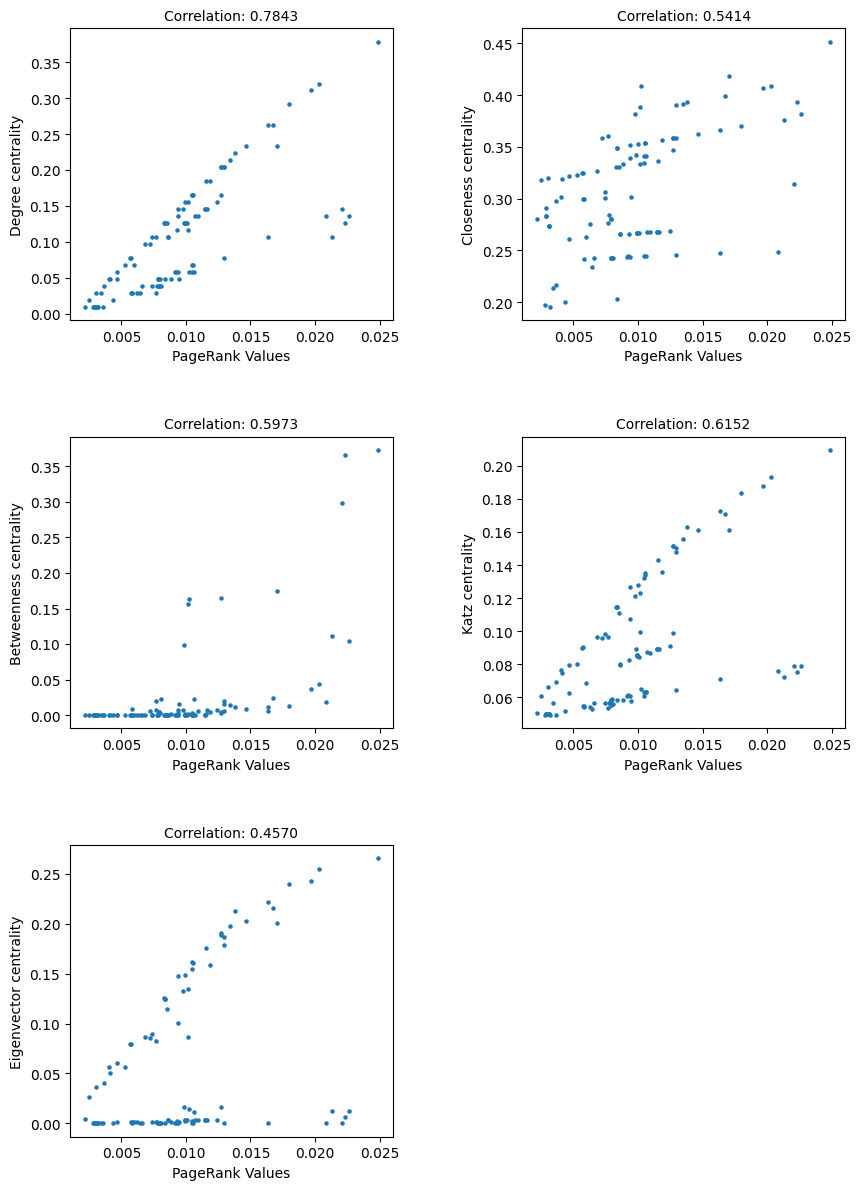

In [172]:
cases_for_corr = [['PageRank Values', list(nx.pagerank(G1).values())],
         ['Degree centrality', list(nx.degree_centrality(G1).values())], 
         ['Closeness centrality',  list(nx.closeness_centrality(G1).values())], 
         ['Betweenness centrality',  list(nx.betweenness_centrality(G1).values())],
         ['Katz centrality',  list(nx.katz_centrality(G1, 1/30, 10000).values())],
         ['Eigenvector centrality',  list(nx.eigenvector_centrality(G1).values())]]

plt.figure(figsize=(2*5, 5*5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
k = 1
for i in [0]:
  for j in range(i + 1, len(cases_for_corr)):
      i_label, i_vals = cases_for_corr[i]
      j_label, j_vals = cases_for_corr[j]
      correlation = scipy.stats.pearsonr(i_vals, j_vals)[0]
      plt.subplot(5, 2, k)
      plt.scatter(i_vals, j_vals, s=5)
      plt.title('Correlation: {:.4f}'.format(correlation),  fontdict = {'fontsize' : 10})
      plt.xlabel(i_label)
      plt.ylabel(j_label)
      k += 1

#### Assortative mixing by node attributes and node degree.

* Assortative network (r > 0): hubs (high degree nodes) tend to
connect to hubs, low degree nodes to low degree nodes
* Disassortative network (r <0): high degree nodes connected to
low degree nodes, star-like structure

Lets see assortativity coefficient

In [175]:
for attrib in list(nodes[4825797].keys())[1:3]:
    modularity = nx.attribute_assortativity_coefficient(G1, attrib)
    print(attrib, modularity)

sex 0.024847964151547244
city 0.029617626386242765


We find a little value for the assortativity coefficient of sex and city, indicating low assortative mixing. 
That in general there is no strong tendency to connect nodes with the same attributes given, i.e. they are not representative in our graph

Considering the values of assortative mixing in more detail

In [176]:
cities = list(set([f[3] for f in myFriends_list if int(f[0]) in list(G1.nodes())]))
sexs = list(set([f[2] for f in myFriends_list if int(f[0]) in list(G1.nodes())]))

<Figure size 1600x400 with 0 Axes>

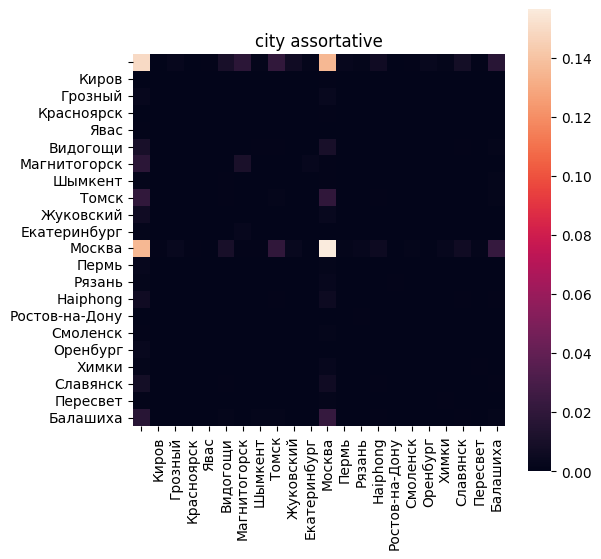

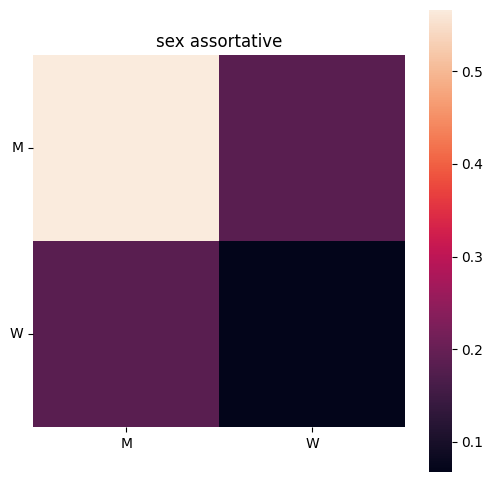

In [177]:
import seaborn as sns
plt.figure(figsize=(16,4))
for idx, title, attr_list in [[1, 'city', cities],[2, 'sex', sexs]]:
    mapping = {c:id for id, c in enumerate(attr_list)}
    mixing = nx.attribute_mixing_matrix(G1, title, mapping=mapping)
    fig = plt.figure(figsize=(6, 6))
    plt.title(f"{title} assortative")
    hmap = sns.heatmap(
        mixing,
        cbar=True,
        square=True)
    hmap.set_xticklabels([m for m in mapping])
    hmap.set_yticklabels([m for m in mapping], rotation=0)
    plt.show()

For example, a high trend of communication between male nodes, or communication between people living in Moscow. But in general, single high values ​​certainly do not greatly affect to general assortativity_coefficient of attribute

#### Node structural equivalence/similarity

For node structural equivalence calculation let's use the algorithms:
* Adjency matrix
* Pearson similarity
* Jaccard similarity
* Cosine similarity

Without special preprocess procedures an adjacency matrix can look very noisy and hide network's structure. There are some procedures of node reordering that provides a better view of the network's adjacency matrix. Reverse Cuthill-McKee finds permutation of the nodes that minimizes the bandwidth of the matrix

In [42]:
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix
import seaborn as sns
order = scipy.sparse.csgraph.reverse_cuthill_mckee(scipy.sparse.csr_matrix(nx.to_numpy_array(G1)))

In [67]:
def sim_values(A, i, j):
    cos = (A[i] * A[j]).sum() / np.sqrt(A[i].sum()) / np.sqrt(A[j].sum())
    jac = (A[i] * A[j]).sum() / (((A[i] + A[j])) > 0).sum()
    cov = np.cov(A[i], A[j])
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    return (pearson, jac, cos)

def take_sim(grpah):
    A = nx.to_numpy_array(grpah)
    cos_sim = np.zeros(A.shape)
    pearson_sim = np.zeros(A.shape)
    jaccard_sim = np.zeros(A.shape)
    for i in range(len(grpah)):
        for j in range(i, (len(grpah))):
            pval, jval, cval = sim_values(A, i, j)
            pearson_sim[i, j] = pval
            pearson_sim[j, i] = pval
            jaccard_sim[i, j] = jval
            jaccard_sim[j, i] = jval
            cos_sim[i, j] = cval
            cos_sim[j, i] = cval
    return [pearson_sim, jaccard_sim, cos_sim]

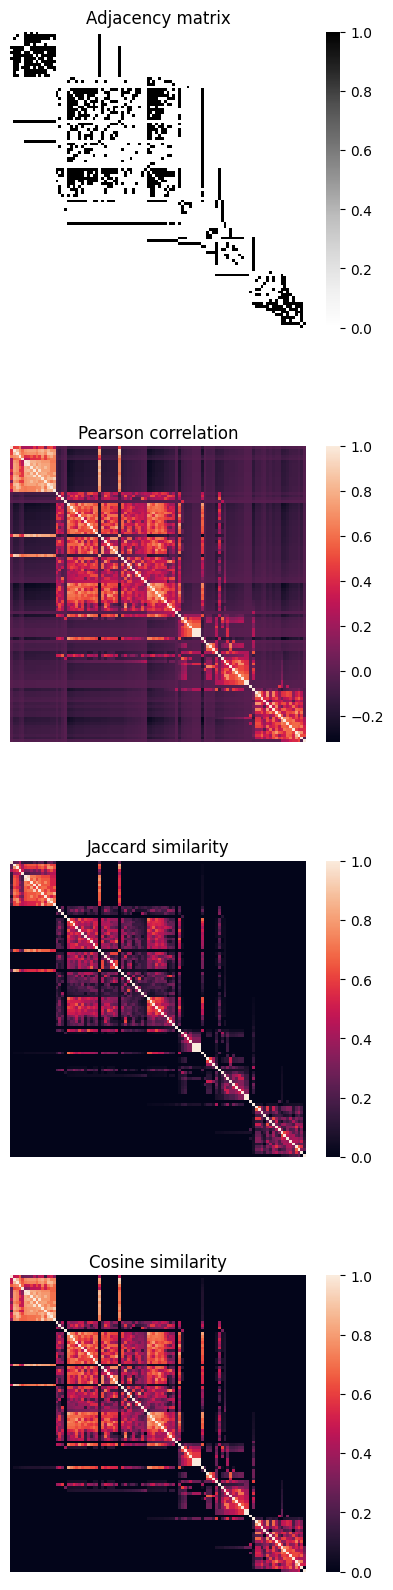

In [68]:
A  = nx.to_numpy_array(G1)
pearson_sim, jaccard_sim, cos_sim = take_sim(G1)

fig = plt.figure(figsize=(5, 5*4))

plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix', order], 
         [2, pearson_sim, None, 'Pearson correlation', order],
         [3, jaccard_sim, None, 'Jaccard similarity', order], 
         [4, cos_sim, None, 'Cosine similarity', order]]


newLabs = np.array([nodes[i]['name'] for i in G.nodes])
for i, matrix, cmap, t, o in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=True,
        square=True,
        xticklabels=0,
        yticklabels=0)
    plt.title(t)

We get a rather interesting picture. We can define approximately 5 graph hubs. That is, we are already using the similarity of matrices, we can detect the comunities

### **Community Detection**

#### Clique search

Cluque is a complete subgraph — a simple model of a community. Find the largest cliques in the graph by nx.find_cliques and visualize them.

In [223]:
cliques = list(nx.find_cliques(G1))
top_cliques = sorted(cliques, key=len, reverse=True)[0:2]
color = [(200/255,50/255, 50/255), (50/255,50/255, 250/255)]
layout = nx.kamada_kawai_layout(G1)
def draw_cliques(clique):
    node_color = []
    for nodes in G1.nodes:
        if nodes in clique:
            node_color.append(color[0])
        else:
            node_color.append(color[1])

    line_width = []
    probability_edges = list(itertools.permutations(clique, 2))
    for edges in G1.edges:
        if edges in probability_edges:
            line_width.append(1)
        else:
            line_width.append(0.2)
    return node_color, line_width

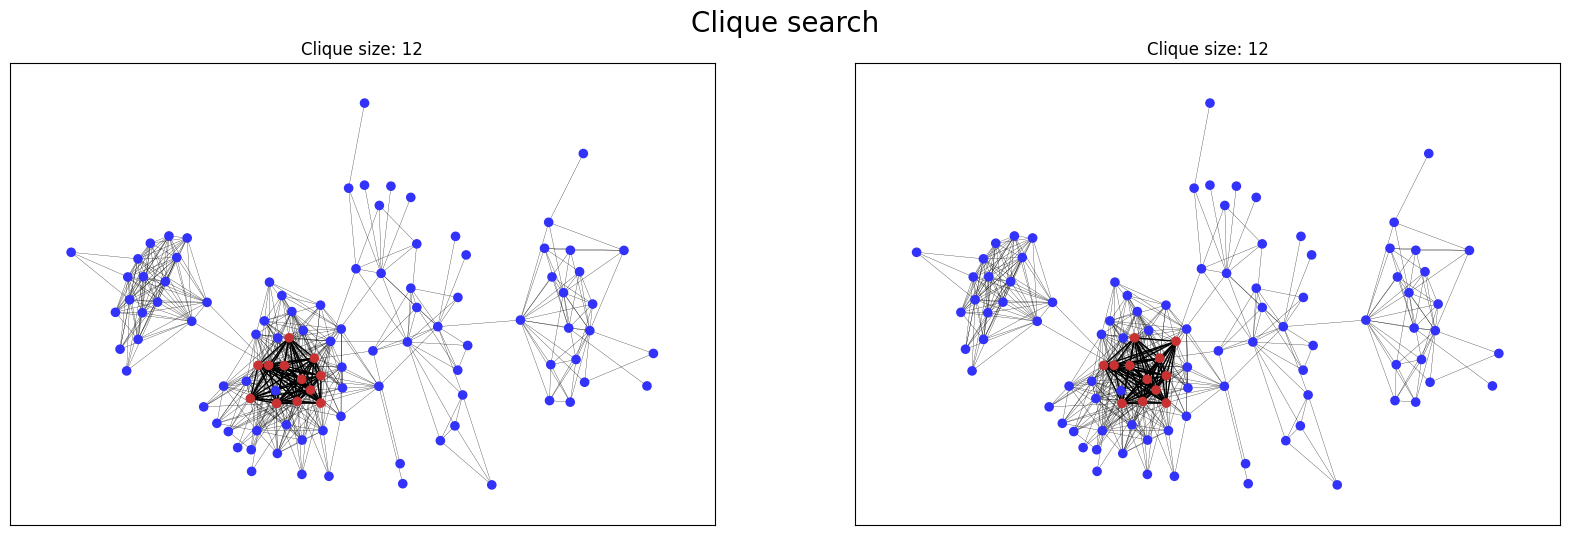

In [231]:
fig = plt.figure(figsize = (20, 6))
plt.title('Clique search', y=1.05, fontdict = {'fontsize' : 20})
plt.axis('off')
for i in range(1, len(top_cliques) + 1):
    ax1 = fig.add_subplot(1, 2, i)
    clique = top_cliques[i - 1]
    node_color, line_width = draw_cliques(clique)
    nx.draw_networkx_nodes(G1, pos=layout, node_size=35, node_color = node_color)
    nx.draw_networkx_edges(G1, pos=layout, width=line_width)
    ax1.set_title('Clique size: '+ str(len(clique)))
plt.show()

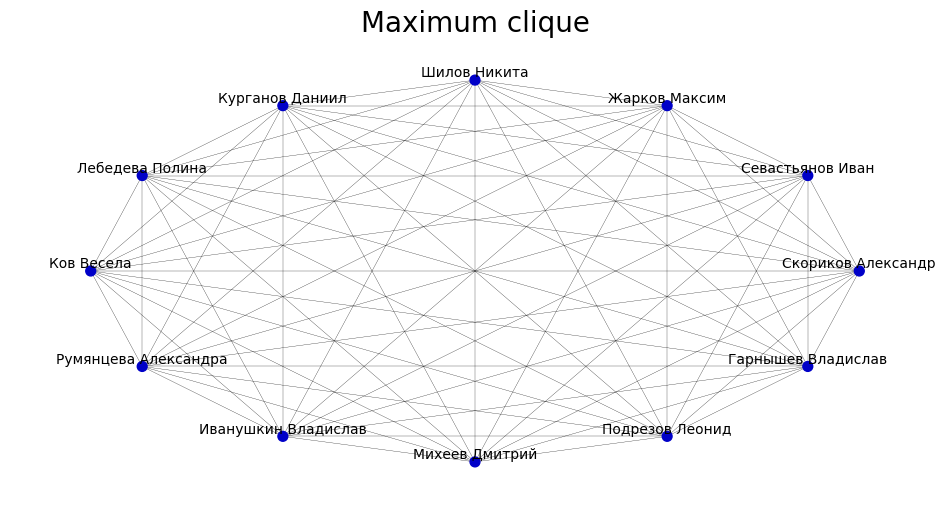

In [219]:
max_clique = sorted(list(nx.find_cliques(G1)), key = len, reverse=True)[:1]
maximum_clique_subgraph1 = G.subgraph(max_clique[0])
#maximum_clique_subgraph2 = G.subgraph(max_clique[1])
simple_graph_plot(maximum_clique_subgraph1, 'Maximum clique', draw_name_label=True, figsize=(12,6), node_size=50, label_size=10, title_size=20)
#simple_graph_plot(maximum_clique_subgraph2, 'Maximum clique', draw_name_label=True, figsize=(6,3))

So we got the biggest clique. In reality, this graph describes my study group at the university

#### K-cores

Let us apply k-core decomposition from networkx.

A k-core is the largest subgraph such that each vertex is connected
to at least k others in subset.

Every vertex in k-core has a degree ki ≥ k
(k + 1)-core is always subgraph of k-core
The core number of a vertex is the highest order of a core that contains
this vertex.

In [95]:
def k_core_decompose(G):
    return np.array(list(nx.core_number(G).values()))

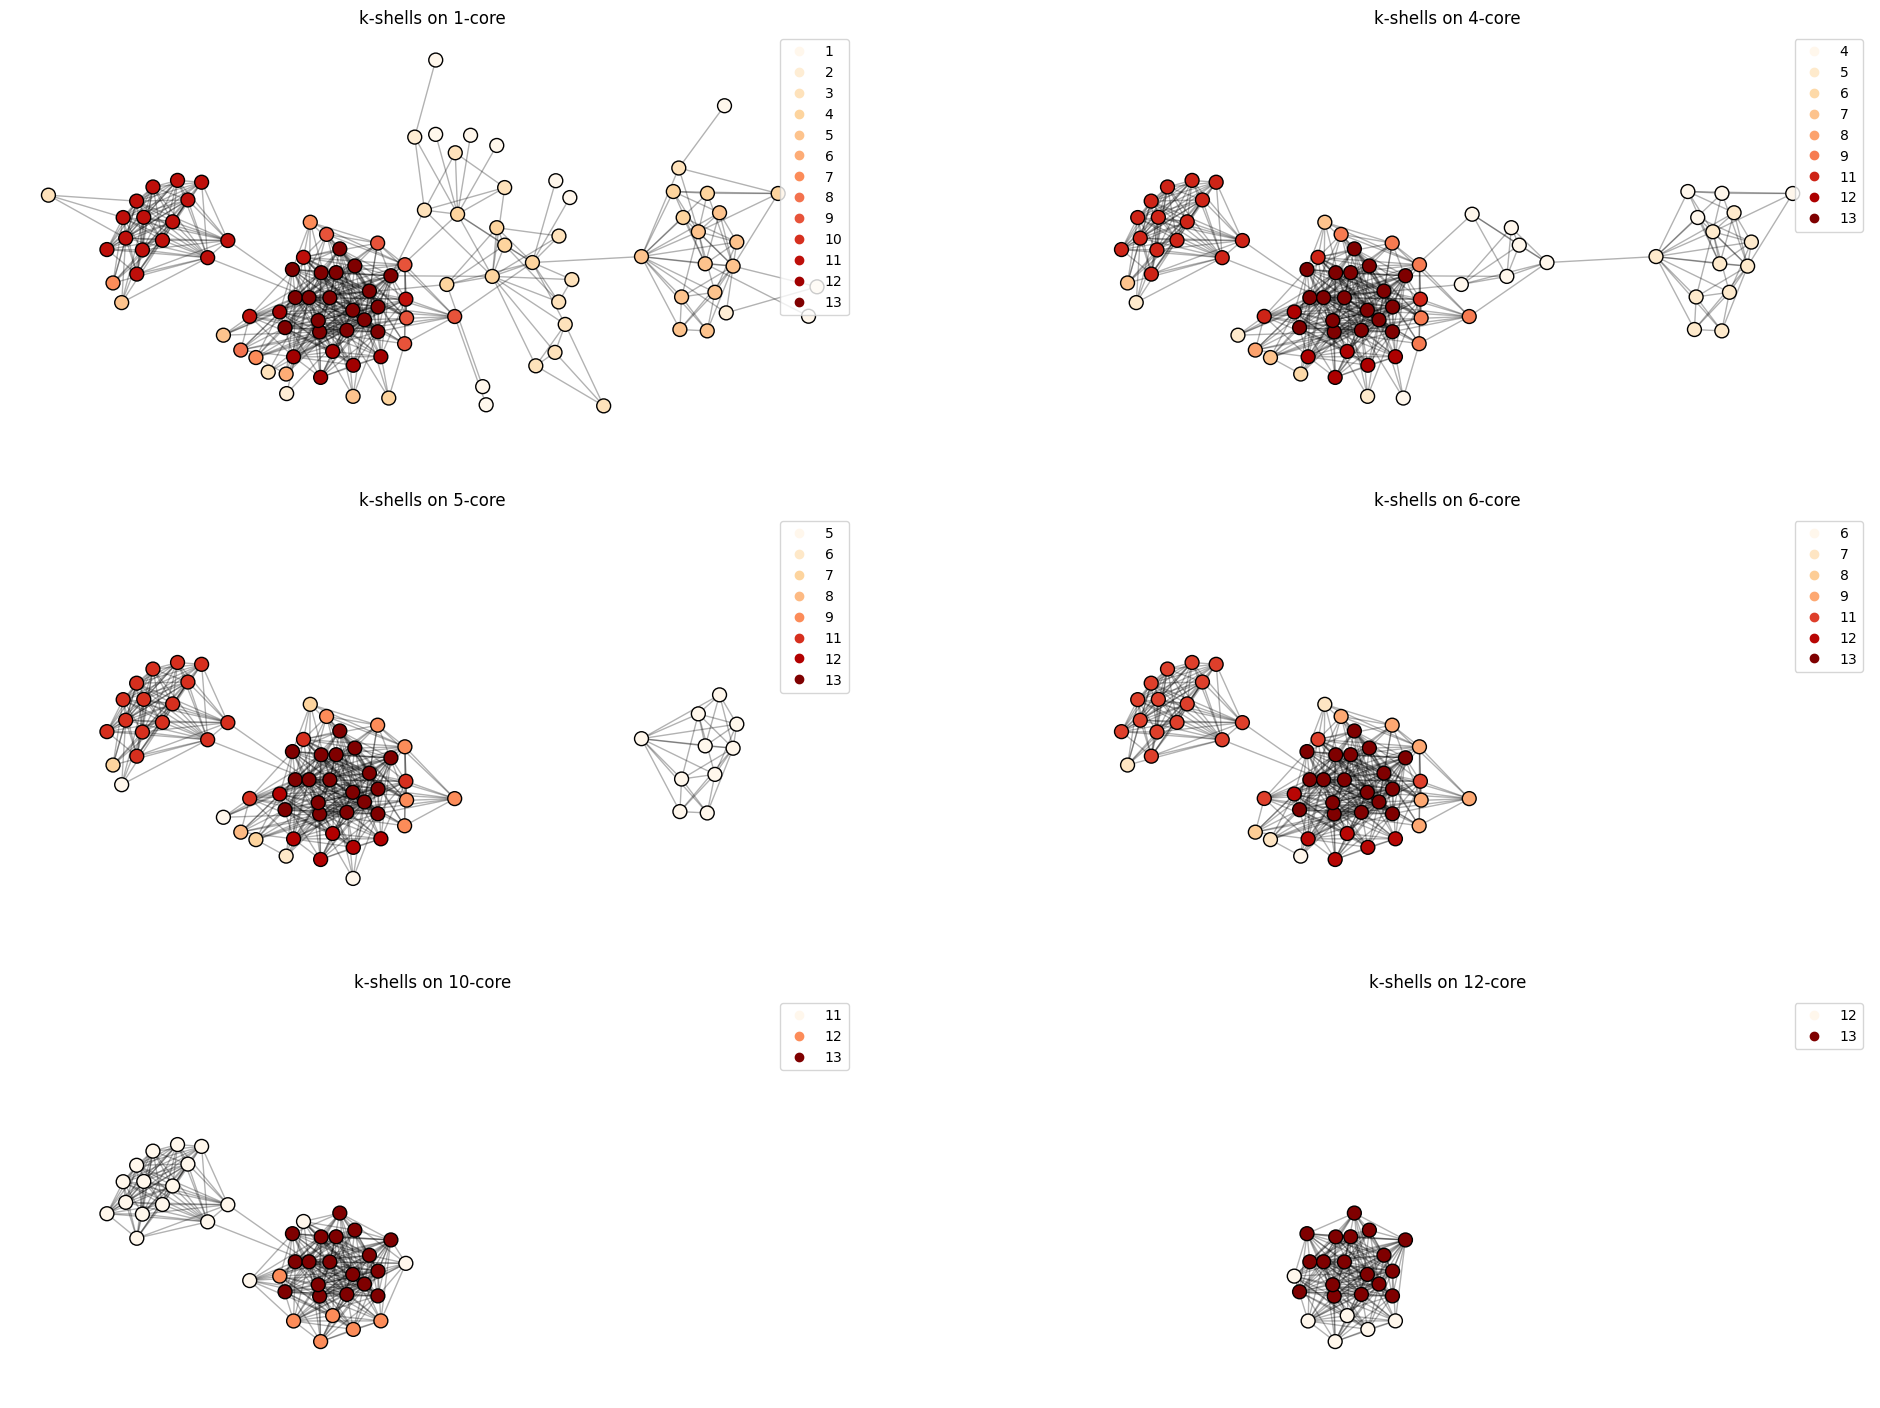

In [238]:
plt.figure(figsize=(8*3, 8*3))
lespos = nx.kamada_kawai_layout(G1)

x_max, y_max = np.array(list(lespos.values())).max(axis=0)
x_min, y_min = np.array(list(lespos.values())).min(axis=0)

for idx, i in enumerate([0,3,4,5,9,11]):
    plt.subplot(4, 2, idx+1)
    subG = nx.k_core(G1, i+1)
    nodes = nx.draw_networkx_nodes(
        subG, 
        lespos,
        cmap=plt.cm.OrRd,
        node_color=k_core_decompose(subG), 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        subG, 
        lespos,
        alpha=0.3,
        width=1, 
        edge_color='black'
    )
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements())
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

#### Agglomerative clustering algorithm

The agglomerative clustering is the most common type of hierarchical clustering used to group objects in clusters based on their similarity. It’s also known as AGNES (Agglomerative Nesting). The algorithm starts by treating each object as a singleton cluster. Next, pairs of clusters are successively merged until all clusters have been merged into one big cluster containing all objects. The result is a tree-based representation of the objects, named dendrogram.

In [298]:
from sklearn.cluster import AgglomerativeClustering

def simrank_distance(G):
    simrank = nx.simrank_similarity(G)
    simrank_matrix = np.array([[simrank[i][j] for i in G] for j in G])
    simrank_matrix = np.around(simrank_matrix, 7)
    distance = np.ones(simrank_matrix.shape) - simrank_matrix 
    return distance

def agglomerative_clustering(distance, max_distance):
    clustering = AgglomerativeClustering(n_clusters = None, distance_threshold = max_distance, linkage = 'complete', compute_full_tree=True,
    affinity='precomputed').fit(distance)
    return clustering.labels_

Now let's build a dendrogram and choose by eye the boundary value which determines the number of comunities we get

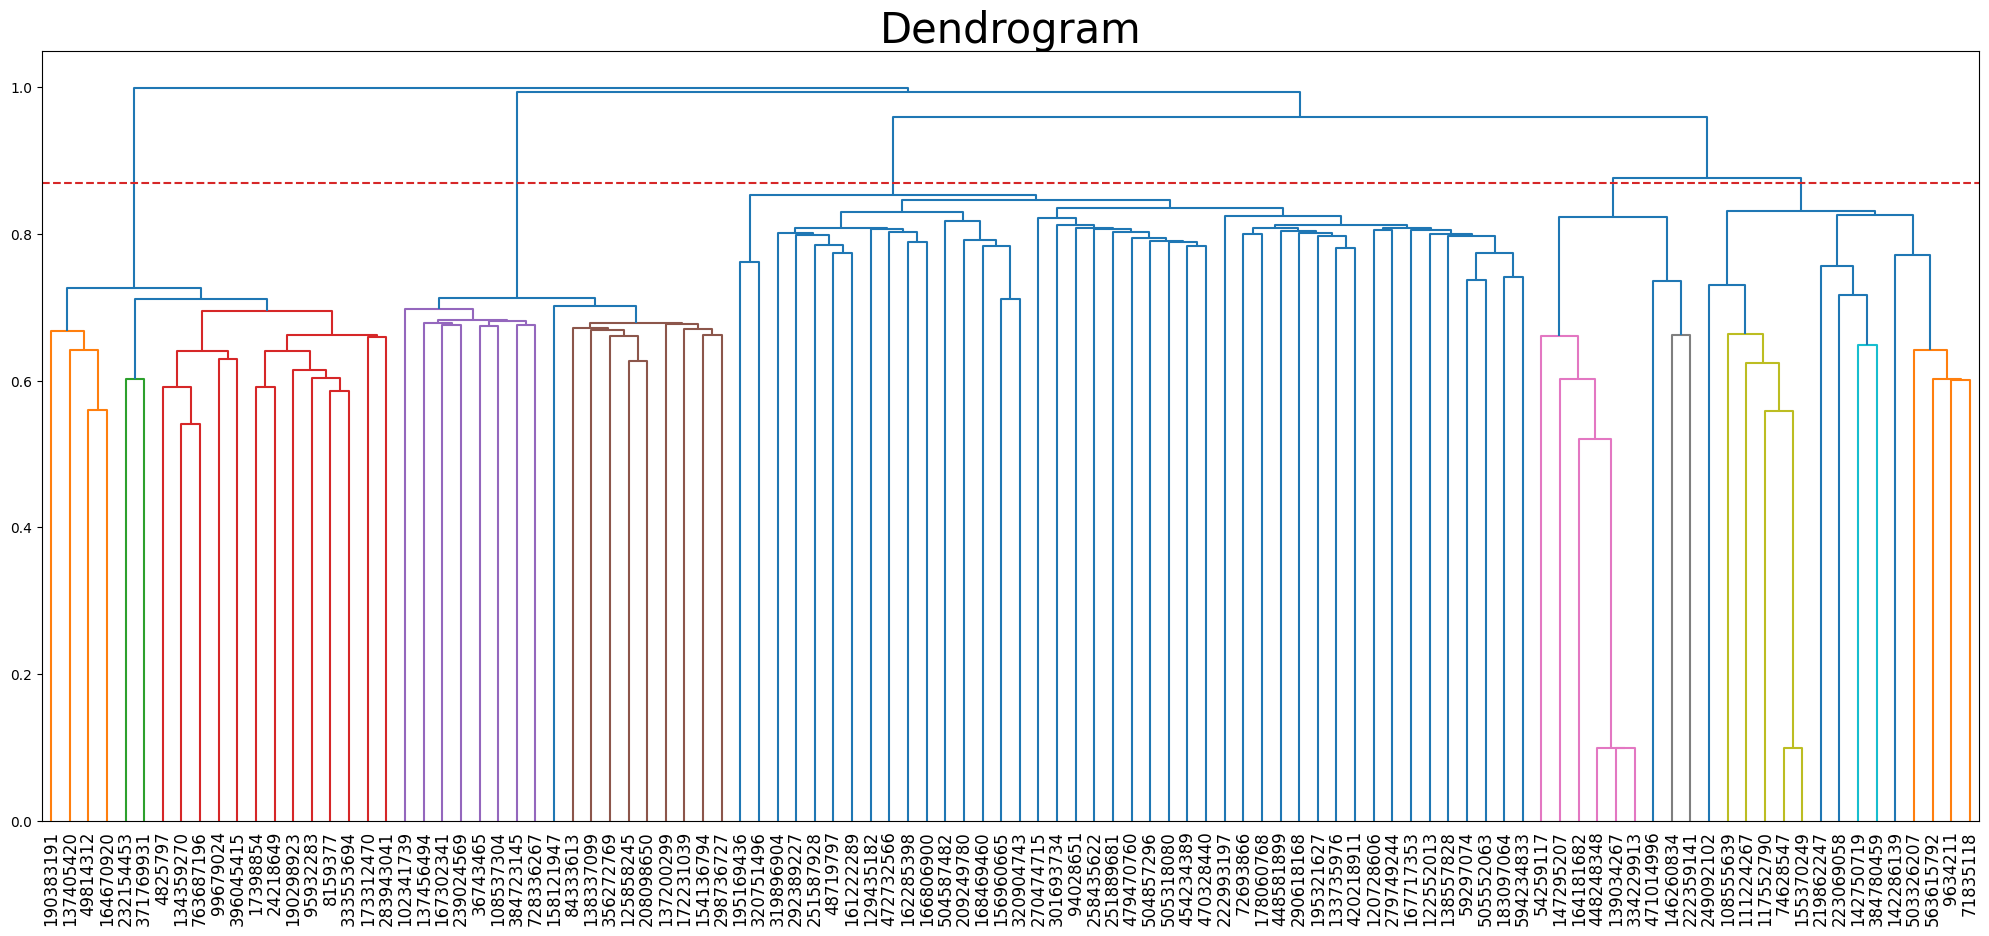

In [299]:
distance = simrank_distance(G1)
plt.figure(figsize=(25, 10))
linked = linkage(squareform(distance), 'complete')
dendrogram(linked, labels=list(G1.nodes), 
           leaf_font_size=12)
shread = 0.87
plt.plot([0, 1500], [shread,shread], linestyle='--', c='tab:red')
plt.title(f'Dendrogram', fontdict = {'fontsize' : 30})
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


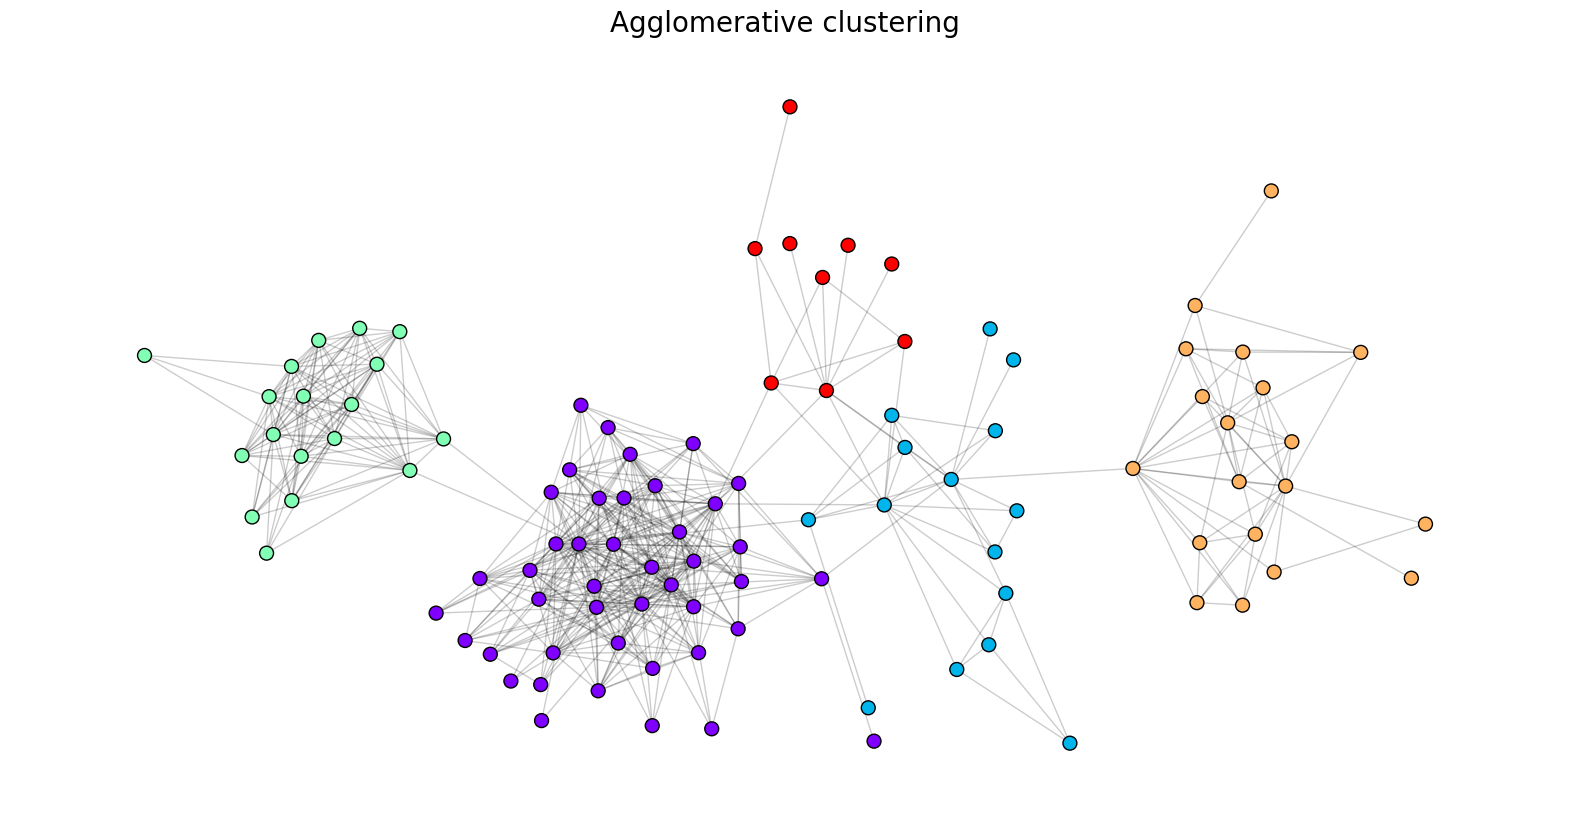

In [301]:
labels = agglomerative_clustering(distance, shread)
lespos = nx.kamada_kawai_layout(G1)
plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(
    G1, 
    lespos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G1,
    lespos,
    alpha=0.2,
    edge_color='black'
)
#nx.draw_networkx_labels(G1, pos=layout, labels=nx.get_node_attributes(G1, "name"), font_size=7, verticalalignment='bottom')
plt.axis('off')
plt.title('Agglomerative clustering', fontdict = {'fontsize' : 20})
plt.show()

We got a pretty accurate representation of the communities:
* Green: HSE magistr's comunity
* Purple:  BMSTU bachelor's students comunity
* Red: Tutor Work comunity
* Blue: Hostel comunity
* Orange: Family and relatives comunity

Of course, there are certain nodes that fall out of the resulting clustering, but in general, this method coped with the task.

#### Girvan-Newman algorithm

The Girvan-Newman algorithm for the detection and analysis of community structure relies on the iterative elimination of edges that have the highest number of shortest paths between nodes passing through them. By removing edges from the graph one-by-one, the network breaks down into smaller pieces, so-called communities. The algorithm was introduced by Michelle Girvan and Mark Newman


We takes a graph, number of iterations of Girvan Newman algorithm and save modularity after each iteration of algorithm.

In [366]:
from networkx.algorithms import community
import itertools

num_of_iterations=16
num_of_community = []
communities_list = []
modularity_scores = []
comunity_girvan_newman= community.girvan_newman(G1)

for i in range(num_of_iterations):
    num_of_community.append(i+2)
    communities = next(comunity_girvan_newman)
    communities_list.append(list(sorted(c) for c in communities))
    modularity_scores.append(community.modularity(G1, communities_list[i]))

Draw madularity dependency graphic to choose num of comunities

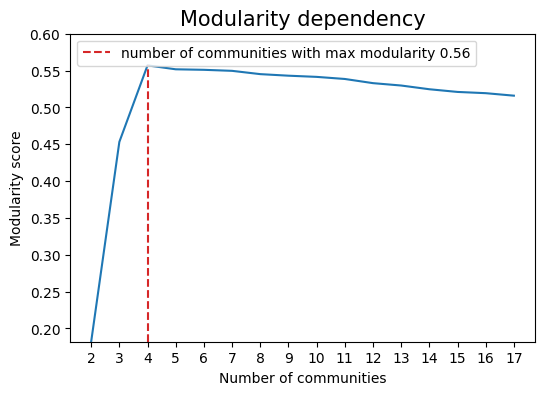

In [369]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(num_of_iterations)+2, modularity_scores)
best_n = np.argmax(modularity_scores) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(modularity_scores))
plt.plot(
    [best_n, best_n], [min(modularity_scores), max(modularity_scores)], 
    linestyle='--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.xticks(np.arange(num_of_iterations)+2)
plt.ylim((min(modularity_scores), 0.6))
plt.title('Modularity dependency', fontdict = {'fontsize' : 15})
plt.show()

Choose number of comunities based on best modularity value. And draw graph

In [428]:
best_num_of_comunities = 4

best_communities = list(communities_list[best_num_of_comunities-2])
labeles = []
for i in list(G1.nodes):
  if i in best_communities[0]:
    labeles.append(0)
  elif i in best_communities[1]:
    labeles.append(1)
  elif i in best_communities[2]:
    labeles.append(2)
  else:
    labeles.append(3)

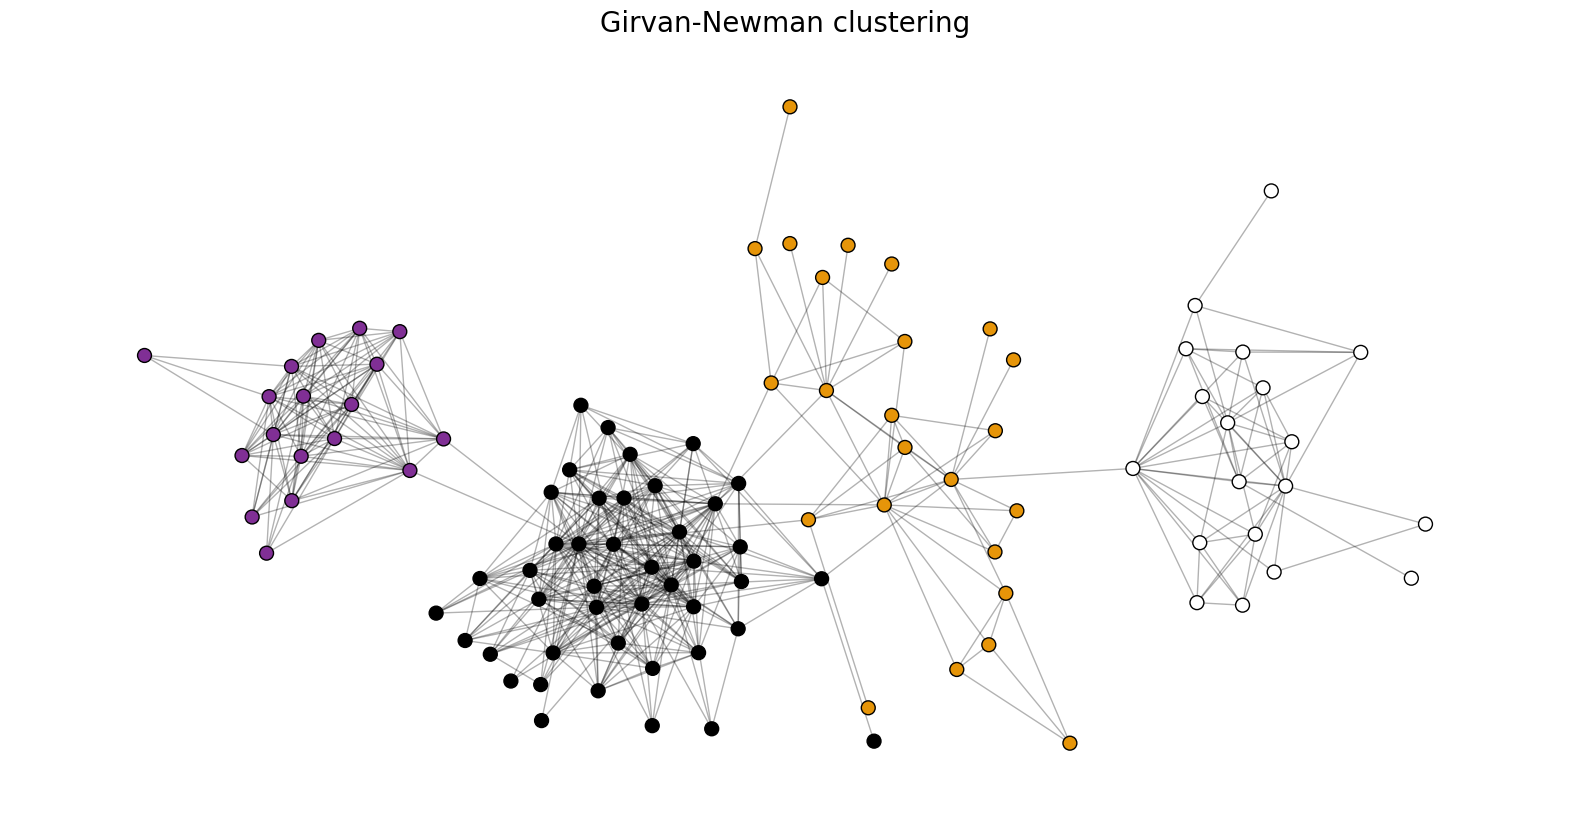

In [429]:
lespos = nx.kamada_kawai_layout(G1)
plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(
    G1, 
    lespos,
    cmap=plt.cm.CMRmap_r,
    node_color=labeles, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G1,
    lespos,
    alpha=0.3,
    edge_color='black'
)
#nx.draw_networkx_labels(G1, pos=layout, labels=nx.get_node_attributes(G1, "name"), font_size=7, verticalalignment='bottom')
plt.axis('off')
plt.title('Girvan-Newman clustering', fontdict = {'fontsize' : 20})
plt.show()

As we can see, using this algorithm, we also found comunities well, only their number is now 4 (that is, the third community is monolithic and cannot be identified). Of course, you can try to choose another best_num_of_comunities and perhaps the result will be close to the Agglomerative clustering algorithm.

In [459]:
%%shell
jupyter nbconvert --to html /content/NS_NSProject_Rudenkov.ipynb

[NbConvertApp] Converting notebook /content/NS_NSProject_Rudenkov.ipynb to html
[NbConvertApp] Writing 8405623 bytes to /content/NS_NSProject_Rudenkov.html
